In [ ]:
import torch
print(torch.__version__)

2.5.1+cu121


In [ ]:
!python --version

Python 3.10.12


# <font color = 'indianred'>**Multilabel Classification of Emotion Tweet Dataset using LLAMA Models** </font>























# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [ ]:
import sys
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gc
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

In [ ]:

import torch

def check_cuda():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
    else:
        print("CUDA is not available. Using CPU.")

check_cuda()

CUDA is available. Using GPU: NVIDIA A100-SXM4-40GB


In [ ]:
# pip install evaluate bitsandbytes trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 re

<font color = 'indianred'> *Load Libraries* </font>

In [ ]:
# standard pythgion libraries
from pathlib import Path
import re
import gc
import time
from typing import Dict, List, Union, Optional
from tqdm import tqdm
import itertools
import json
import joblib
import ast
from datetime import datetime
from difflib import get_close_matches

# Data Science librraies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

# Pytorch
import torch
import torch.nn as nn

# Huggingface Librraies
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    AutoPeftModelForCausalLM,
    PeftConfig
)

from huggingface_hub import login

# Logging and secrets
import wandb
from google.colab import userdata


In [ ]:
set_seed(42)

In [144]:
import os
from pathlib import Path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the working directory to the NLP folder in your Drive
nlp_folder = Path('/content/drive/My Drive/NLP')
os.chdir(nlp_folder)

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

# Define the base path (now the NLP folder)
basepath = nlp_folder

# Create the data folder, model folder, and custom functions folder
data_folder = Path(basepath) / 'data_folder'
model_folder = Path(basepath) / 'lect 7' / 'assignment 7'/ 'sentiment' / 'nn' # Updated path
custom_functions = Path(basepath) / 'lect 7' / 'assignment 7' /'CustomFiles'  # Updated path

# Create the necessary directories if they don't exist
model_folder.mkdir(exist_ok=True, parents=True)
custom_functions.mkdir(exist_ok=True, parents=True)

# Verify that the folders are created
print(f"Model folder created: {model_folder.exists()}")
print(f"Custom functions folder created: {custom_functions.exists()}")

In [ ]:
import wandb

# Log into WandB
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
from huggingface_hub import login

login()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# <font color = 'indianred'> **2. Load Data set**
    


In [ ]:
import pandas as pd
import numpy as np
df_train = pd.read_csv(data_folder /'train.csv')

In [ ]:
df_train.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
df_test = pd.read_csv(data_folder /'test.csv')

In [ ]:
df_test.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,I blew that opportunity -__- #mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,This time in 2 weeks I will be 30... 😥,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


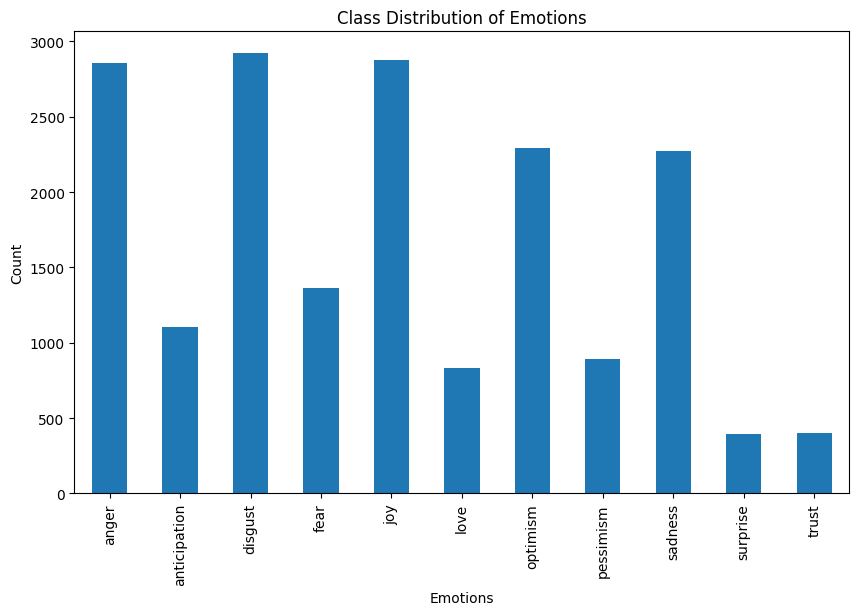

In [ ]:
# List of emotion labels
labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Sum each column to get the count of 1s (positive examples) for each emotion
class_distribution = df_train[labels].sum()

# Display the class distribution
print(class_distribution)

# Optionally, you can plot the distribution using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.show()

In [ ]:
# Check for null values in df_train
null_values_train = df_train.isnull().sum()

# Check for null values in df_test
null_values_test = df_test.isnull().sum()

# Display the results
print("Null values in df_train:\n", null_values_train)
print("\nNull values in df_test:\n", null_values_test)


In [ ]:
!pip install emoji

In [ ]:
import re
import spacy
from nltk.tokenize import TweetTokenizer
from bs4 import BeautifulSoup
import emoji
import os

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def preprocess_tweet(tweet, lemmatize=True, lower=True, remove_stop=True,
                     remove_punct=True, remove_num=False, remove_url=True,
                     remove_mentions=True, remove_emoji=True, remove_hashtags=False):
    """
    Preprocesses a tweet by applying various cleaning steps:
    - Lemmatization
    - Lowercasing
    - Stopword, punctuation, URL, number, and mention removal
    - Emoji and hashtag handling

    Parameters:
    - lemmatize: Whether to apply lemmatization using Spacy.
    - lower: Whether to lowercase the tweet.
    - remove_stop: Whether to remove stopwords.
    - remove_punct: Whether to remove punctuation.
    - remove_num: Whether to remove numbers.
    - remove_url: Whether to remove URLs.
    - remove_mentions: Whether to remove @mentions.
    - remove_emoji: Whether to remove emojis.
    - remove_hashtags: Whether to remove the hashtag symbol (#) but keep the word.

    Returns:
    - Cleaned tweet as a string.
    """
    try:
        # Basic cleanup: remove URLs, mentions, and special characters
        if remove_url:
            tweet = re.sub(r"http\S+|www\S+", "", tweet)
        if remove_mentions:
            tweet = re.sub(r"@\w+", "", tweet)

        # Optionally remove emojis and replace with text
        if remove_emoji:
            tweet = emoji.demojize(tweet)

        # Optionally remove hashtags but keep the word
        if remove_hashtags:
            tweet = re.sub(r"#", "", tweet)

        # Remove HTML tags if present
        soup = BeautifulSoup(tweet, "html.parser")
        tweet = soup.get_text()

        # Tokenize the tweet
        tokenizer = TweetTokenizer()
        tokens = tokenizer.tokenize(tweet)

        # Use spaCy for lemmatization and stopword/punctuation/number filtering
        doc = nlp(" ".join(tokens))
        cleaned_tokens = []
        for token in doc:
            if remove_stop and token.is_stop:
                continue
            if remove_punct and token.is_punct:
                continue
            if remove_num and token.like_num:
                continue
            if lemmatize:
                cleaned_tokens.append(token.lemma_)
            else:
                cleaned_tokens.append(token.text)

        # Join tokens back into a single string
        cleaned_tweet = " ".join(cleaned_tokens)

        # Optionally lowercase the tweet
        if lower:
            cleaned_tweet = cleaned_tweet.lower()

        return cleaned_tweet.strip()

    except Exception as e:
        print(f"An error occurred: {e}")
        return ""



In [ ]:
# # Apply preprocessing to each tweet
# df_train['cleaned_tweet'] = df_train['Tweet'].apply(preprocess_tweet)
# # Apply preprocessing to each tweet
# df_test['cleaned_tweet'] = df_test['Tweet'].apply(preprocess_tweet)
# print(df_train[['Tweet', 'cleaned_tweet']])

# Apply the updated preprocess_tweet function to each tweet in the training set
df_train['cleaned_tweet'] = df_train['Tweet'].apply(lambda x: preprocess_tweet(x,
                                                                               lemmatize=False,
                                                                               lower=False,
                                                                               remove_stop=False,
                                                                               remove_punct=True,
                                                                               remove_num=False,
                                                                               remove_url=False,
                                                                               remove_mentions=True,
                                                                               remove_emoji=True,
                                                                               remove_hashtags=True))

# Apply the updated preprocess_tweet function to each tweet in the test set
df_test['cleaned_tweet'] = df_test['Tweet'].apply(lambda x: preprocess_tweet(x,
                                                                             lemmatize=False,
                                                                             lower=False,
                                                                             remove_stop=False,
                                                                             remove_punct=True,
                                                                             remove_num=False,
                                                                             remove_url=False,
                                                                             remove_mentions=True,
                                                                             remove_emoji=True,
                                                                             remove_hashtags=True))

# Display original and cleaned tweets for comparison
print(df_train[['Tweet', 'cleaned_tweet']].head(10))


<ipython-input-47-fb57640ffec9>:51: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(tweet, "html.parser")
<ipython-input-47-fb57640ffec9>:51: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(tweet, "html.parser")


In [ ]:
# Step 1: Identify the label columns (all columns except 'ID' and 'Tweet')
emotion_columns = [col for col in df_train.columns if col not in ['ID', 'Tweet','cleaned_tweet']]
# emotion_columns = [col for col in df_train.columns if col not in ['ID', 'Tweet']]

# Step 2: Split the train_df into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    df_train['cleaned_tweet'], df_train[emotion_columns], test_size=0.2, random_state=42)

# X_train, X_valid, y_train, y_valid = train_test_split(
#     df_train['Tweet'], df_train[emotion_columns], test_size=0.2, random_state=42)



In [ ]:
# Function to convert label row to binary vector
def convert_labels_to_vector(label_row):
    # Create a binary vector for the labels
    return [1 if label != 'NONE' else 0 for label in label_row]

# Step 3: Prepare the test data (use test_df['cleaned_tweet'] and test_df[label_columns])
X_test = df_test['cleaned_tweet'].tolist()
# X_test = df_test['Tweet'].tolist()
y_test = df_test[emotion_columns].apply(convert_labels_to_vector, axis=1).values.tolist()

# Convert X_train, X_valid, and X_test to lists, and the corresponding labels to lists of lists
X_train = X_train.tolist()
y_train = y_train.values.tolist()

X_valid = X_valid.tolist()
y_valid = y_valid.values.tolist()



In [ ]:

# Define the label columns
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

def convert_to_labels(y, label_columns):
    return [[label_columns[i] for i, val in enumerate(row) if val == 1] for row in y]


# Step 4: Create trainset, validset, and testset using Dataset.from_dict
trainset = Dataset.from_dict({
    'text': X_train,
    'label': convert_to_labels(y_train, label_columns)
})

validset = Dataset.from_dict({
    'text': X_valid,
    'label': convert_to_labels(y_valid, label_columns)
})

testset = Dataset.from_dict({
    'text': X_test,
    'label': convert_to_labels(y_test, label_columns)
})

from datasets import Dataset, DatasetDict
import pandas as pd



# # Function to transform each Dataset to the desired format
# def transform_dataset(dataset):
#     df = dataset.to_pandas()
#     # df.insert(0, 'ID', range(1, len(df) + 1))  # Add ID column
#     df = df.rename(columns={'text': 'Tweet'})  # Rename 'texts' to 'Tweet'

#     # Convert the 'labels' column to individual label columns
#     labels_df = pd.DataFrame(df['label'].tolist(), columns=label_columns)
#     df = pd.concat([df[['Tweet']], labels_df], axis=1)

#     # Convert back to Hugging Face Dataset
#     return Dataset.from_pandas(df)

# Transform each dataset and create DatasetDict
dataset_dict = DatasetDict({
    "train": trainset,
    "validation": validset,
    "test": testset
})

# Check the final structure
print(dataset_dict)

In [ ]:
dataset_dict['train'][1:5]

{'text': ["We 're the least known band in the World but so glad you asked muchlove",
  'Unruly kids at 8 am in the morning nothanks ripping the flower beds up by the roots while their parents watch shocking',
  'Ok but I just got called a White Devil on the train and I did nt know whether to laugh or be offended',
  'you are so wrong for this needed levity after that recording'],
 'label': [['joy', 'love', 'optimism'],
  ['anger', 'disgust', 'fear', 'surprise'],
  ['fear', 'surprise'],
  ['anger', 'disgust']]}

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>



<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [ ]:
# Split the test set into test and validation sets
# test_val_splits = stack_selected_columns_final.train_test_split(test_size=0.4, seed=42)
# train_split= test_val_splits['train']
# test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
# val_split = test_val_splits['train']
# test_split = test_val_splits['test']


<font color = 'indianred'>*small subset for initial experimenttaion*</font>

In [ ]:
# train_split = train_split.shuffle(seed = 42).select(range(2000))
# val_split = val_split.shuffle(seed = 42).select(range(2000))
# test_split = test_split.shuffle(seed = 42).select(range(2000))

In [ ]:
train_val_subset= DatasetDict(
    {"train": dataset_dict['train'], "valid": dataset_dict['validation']})

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1545
    })
})

In [ ]:
train_val_subset['train']['label'][0]

['anticipation', 'joy', 'optimism']

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>



In [ ]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [ ]:
free_gpu_memory()

In [ ]:
checkpoint = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
tokenizer.eos_token

'<|eot_id|>'

In [ ]:
tokenizer.pad_token

In [ ]:
tokenizer.pad_token = "<|finetune_right_pad_id|>"

In [ ]:
tokenizer.special_tokens_map

{'bos_token': '<|begin_of_text|>',
 'eos_token': '<|eot_id|>',
 'pad_token': '<|finetune_right_pad_id|>'}

In [ ]:
tokenizer.chat_template

'{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- if strftime_now is defined %}\n        {%- set date_string = strftime_now("%d %b %Y") %}\n    {%- else %}\n        {%- set date_string = "26 Jul 2024" %}\n    {%- endif %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0][\'role\'] == \'system\' %}\n    {%- set system_message = messages[0][\'content\']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = "" %}\n{%- endif %}\n\n{#- System message #}\n{{- "<|start_header_id|>system<|end_header_id|>\\n\\n" }}\n{%- if tools is not none %}\n    {{- "Environment: ipython\\n" }}\n{%- endif %}\n{{- "Cutting

#<font color = 'indianred'> **5. Create Prompts**



In [ ]:
def formatting_prompts_func(examples, input_field, output_field, prompt_template, output_delimiter, tokenizer, include_eos_token=True):
    """Format a single example or batch of examples"""
    # Debug the input type
    # print("Input type:", type(examples))
    # print("Input content:", examples)

    # Convert to dict if it's a LazyRow
    if hasattr(examples, 'keys'):
        examples = dict(examples)

    # Handle single example case (for dataset.map)
    if isinstance(examples, dict):
        if not isinstance(examples[input_field], (list, tuple)):
            input_text = examples[input_field].strip()
            output_text = examples[output_field]
            output_delimiter = output_delimiter.strip()

            prompt = prompt_template.format(input_text, output_delimiter, output_text)

            if include_eos_token:
                prompt = prompt + tokenizer.eos_token

            return prompt.strip()
        else:
            # Handle batch case
            output_prompts = []
            for i in range(len(examples[input_field])):
                input_text = examples[input_field][i].strip()
                output_text = examples[output_field][i]
                output_delimiter = output_delimiter.strip()

                prompt = prompt_template.format(input_text, output_delimiter, output_text)

                if include_eos_token:
                    prompt = prompt + tokenizer.eos_token
                prompt = prompt.strip()
                output_prompts.append(prompt)

            return output_prompts

    print("Unexpected input format!")
    print("Type:", type(examples))
    print("Content:", examples)
    raise ValueError(f"Expected a dictionary with examples, got {type(examples)}")


In [ ]:
prompt_template = 'Classify the TEXT by selecting all applicable labels from the following list: \
["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"].\
 ### TEXT: {} {} {}'

In [ ]:
output_delimiter = "### LABEL:"
input_field = 'text'
output_field = 'label'

In [ ]:
output_delimiter

'### LABEL:'

In [ ]:
from functools import partial

In [ ]:
formatting_prompts_func_final = partial(formatting_prompts_func,
                                        input_field =input_field,
                                        output_field = output_field,
                                        prompt_template=prompt_template,
                                        output_delimiter=output_delimiter,
                                        tokenizer=tokenizer
)

In [ ]:
train_val_subset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 6179
})

In [ ]:
samples = formatting_prompts_func_final(train_val_subset['train'][0:3])

In [ ]:
from pprint import pprint
pprint(samples[2], width=120)

In [ ]:
single_sample = formatting_prompts_func_final(train_val_subset['train'][1])
pprint(single_sample, width=120)

##  <font color = 'indianred'> **5.1 Filter Longer sequences**

In [ ]:
def filter_by_length(example, max_length, tokenizer, prompt_function):
    """Filter a single example based on length"""
    # Convert LazyRow to dict if needed
    example_dict = dict(example) if hasattr(example, 'keys') else example

    prompt = prompt_function(example_dict)  # handles single example
    tokenized_prompt = tokenizer(prompt, add_special_tokens=False, truncation=False, padding=False)
    total_length = len(tokenized_prompt['input_ids'])
    example['keep'] = total_length <= max_length
    return example

# Create partial function
filter_fn = partial(filter_by_length,
                   max_length=1000,
                   tokenizer=tokenizer,
                   prompt_function=formatting_prompts_func_final)

# Now try processing the dataset
train_val_subset = train_val_subset.map(filter_fn, desc="Processing dataset")

Processing dataset:   0%|          | 0/6179 [00:00<?, ? examples/s]

Processing dataset:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'keep'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'label', 'keep'],
        num_rows: 1545
    })
})

In [ ]:
train_val_subset_filtered = train_val_subset.filter(lambda x: x['keep']).remove_columns(['keep'])

Filter:   0%|          | 0/6179 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
train_val_subset_filtered

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1545
    })
})

##  <font color = 'indianred'> **5.2 Data Collator**

In [ ]:
def get_token_ids_in_context(tokenizer, full_string, substring):
    # Tokenize the full string
    full_tokens = tokenizer.encode(full_string, add_special_tokens=False)

    # Find the start and end indices of the substring in the full string
    start_index = full_string.index(substring)
    end_index = start_index + len(substring)

    # Find the corresponding tokens, starting one token earlier
    start_token_index = max(0, len(tokenizer.encode(full_string[:start_index], add_special_tokens=False)) - 1)
    end_token_index = len(tokenizer.encode(full_string[:end_index], add_special_tokens=False))

    return full_tokens[start_token_index:end_token_index]

In [ ]:
# Create a sample prompt format
sample_prompt_format = "some text {} {} {}"

# Create a sample prompt
sample_prompt = sample_prompt_format.format("input", output_delimiter, "output")
sample_prompt

'some text input ### LABEL: output'

In [ ]:
output_delimiter_ids = get_token_ids_in_context(tokenizer, full_string=sample_prompt, substring=output_delimiter )

# Print debug information
print('Original output_delimiter:', output_delimiter)
print('output_delimiter_ids:', output_delimiter_ids)
print('Delimiter tokens:', tokenizer.convert_ids_to_tokens(output_delimiter_ids))
print('Reconstructed output_delimiter:', tokenizer.decode(output_delimiter_ids))

In [ ]:
data_collator_comp = DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, mlm=False,
                                                      response_template=output_delimiter_ids)

#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**

In [ ]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [ ]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,)


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

##  <font color = 'indianred'> **6.2 PEFT Setup**

In [ ]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-0

In [ ]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [ ]:
find_linear_layers(model)

['q_proj',
 'lm_head',
 'up_proj',
 'k_proj',
 'v_proj',
 'gate_proj',
 'o_proj',
 'down_proj']

In [ ]:
TaskType.CAUSAL_LM

<TaskType.CAUSAL_LM: 'CAUSAL_LM'>

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

## <font color = 'indianred'> **6.3 Training Arguments**</font>







In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = model_folder/'llama_qlora_lmh'

# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'tweet_exp_lmh_llama'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = SFTConfig(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=4,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-3,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    model.config.use_cache = False  # Disable caching for compatibility

model.config

LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.

##  <font color = 'indianred'> **6.4 Initialize Trainer**</font>



In [ ]:
# lora_model.config.use_cache = False
trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=train_val_subset_filtered['train'],
        eval_dataset=train_val_subset_filtered['valid'],
        peft_config=peft_config,
        formatting_func =  formatting_prompts_func_final,
        data_collator=data_collator_comp,)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:309: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

## <font color = 'indianred'> **6.5 Setup WandB**</font>

In [ ]:
%env WANDB_PROJECT = multilabel_tweet_classification

##  <font color = 'indianred'> **6.7 Training**

In [ ]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


wandb: Currently logged in as: shobhit-pachauri (shobhit-pachauri-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
20,8.629200,8.317790
40,4.242700,2.985224
60,2.939200,2.918660
80,2.895100,2.894768
100,2.446600,1.953640
120,1.527200,1.040958
140,0.871600,0.726104
160,0.669700,0.609094
180,0.603800,0.613831
200,0.603400,0.603230


Step,Training Loss,Validation Loss
20,8.629200,8.317790
40,4.242700,2.985224
60,2.939200,2.918660
80,2.895100,2.894768
100,2.446600,1.953640
120,1.527200,1.040958
140,0.871600,0.726104
160,0.669700,0.609094
180,0.603800,0.613831
200,0.603400,0.603230


In [ ]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]

In [ ]:
best_model_checkpoint_step

'380'

##  <font color = 'indianred'> **6.8 Validation**

<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [ ]:
model_folder = model_folder
best_model_checkpoint_step
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/My Drive/NLP/lect 7/assignment 7/sentiment/nn/llama_qlora_lmh/llama_qlora_lmh/checkpoint-380'

In [ ]:
from peft import AutoPeftModelForCausalLM, PeftConfig

In [ ]:
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = "<|finetune_right_pad_id|>"
tokenizer.padding_side='left'


In [ ]:
def run_inference(
    seed: int,
    dataset: Union[Dict, List],
    model,
    tokenizer,
    per_device_batch_size: int,
    prompt_template: str,
    input_field: str,
    output_field: str,
    output_delimiter: str,
    save_dir: Optional[Path] = None,
    save_file_name: Optional[str] = None,
    max_new_tokens: int = 10,
    num_beams: int = 1,
    do_sample: bool = False,
    top_k: int = 50,
    top_p: float = 1.0,
    temperature: float = 1.0,
    no_repeat_ngram_size: int = 2,
    num_return_sequences: int = 1
) -> List[Dict]:
    """
    Run inference on a dataset and return complete generations.

    Args:
        seed (int): Random seed for reproducibility
        dataset (Union[Dict, List]): Input dataset containing text to generate from
        model: Pre-trained model to use for inference
        tokenizer: Tokenizer associated with the model
        per_device_batch_size (int): Number of samples to process in each batch
        input_field (str): Key name for accessing input text in the dataset
        output_delimiter: Delimiter used in prompt template
        output_field (str): Key name for accessing ground truth labels in the dataset
        save_dir (Optional[Path]): Directory path to save generation results. If None, results won't be saved
        save_file_name (Optional[str]): Name of the file to save results. If None, uses timestamp
        max_new_tokens (int, optional): Maximum number of tokens to generate. Defaults to 10
        num_beams (int, optional): Number of beams for beam search. Defaults to 1
        do_sample (bool, optional): Whether to use sampling. Defaults to False
        top_k (int, optional): Number of highest probability tokens to keep for top-k sampling. Defaults to 50
        top_p (float, optional): Cumulative probability cutoff for top-p sampling. Defaults to 1.0
        temperature (float, optional): Sampling temperature; higher means more random. Defaults to 1.0
        no_repeat_ngram_size (int, optional): Size of n-grams to prevent repetition. Defaults to 2
        num_return_sequences (int, optional): Number of sequences to generate per input. Defaults to 1

    Returns:
        List[Dict]: List of dictionaries containing:
          - "input": Original input text
          - "generated_output": Model-generated text
          - "ground_truth": Ground truth label if available, "N/A" if not
    """
    set_seed(seed)
    model.eval()
    print(f"Model device for inference: {model.device}")
    device = model.device
    batch_size = per_device_batch_size

    inference_results = []

    progress_bar = tqdm(range(0, len(dataset), batch_size), desc="Generating responses")

    for i in progress_bar:
        # Create a batch
        batch = dataset[i:i + batch_size]

        try:
            texts = batch[input_field]
            labels = batch[output_field] if output_field in batch else ["N/A"] * len(texts)
            prompts = [prompt_template.format(text.strip(), output_delimiter.strip(), "").strip() for text in texts]
            inputs = tokenizer(prompts, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    num_beams=num_beams,
                    do_sample=do_sample,
                    top_k=top_k,
                    top_p=top_p,
                    temperature=temperature,
                    no_repeat_ngram_size=no_repeat_ngram_size,
                    num_return_sequences=num_return_sequences,
                    pad_token_id=tokenizer.pad_token_id,
                )

            decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            for text, label, decoded_output in zip(texts, labels, decoded_outputs):
                inference_results.append({
                    "input": text,
                    "generated_output": decoded_output,
                    "ground_truth": label
                })

            continue

        except Exception as e:
            print(f"Error processing batch: {str(e)}")
            print(f"Problematic batch: {batch}")
            continue

    # Save generations if path provided
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        # If no filename provided, create a timestamped one
        if save_file_name is None:
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_name = f"generations_{timestamp}.json"
        elif not save_file_name.endswith('.json'):
            save_name = f"{save_file_name}.json"

        save_file = save_dir / save_name

        with open(save_file, 'w') as f:
            json.dump(inference_results, f, indent=2)
        print(f"Saved inference_results to: {save_file}")

    return inference_results

In [ ]:
free_gpu_memory()

In [ ]:
valid_inference_results = run_inference(seed = 42,
              dataset=train_val_subset_filtered['valid'],
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=50,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter,
              save_dir=model_folder,
              save_file_name = 'valid_complete_generations')

Generating responses: 100%|██████████| 31/31 [00:31<00:00,  1.03s/it]


In [ ]:
file_name = model_folder/'valid_complete_generations.json'
with open(file_name, 'r') as f:
    valid_inference_results = json.load(f)

In [ ]:
valid_inference_results[0]

In [ ]:
valid_inference_results[1]['generated_output']

In [ ]:
valid_inference_results[2]['generated_output']

In [ ]:
valid_inference_results[3]['generated_output']

In [ ]:
def extract_content(generated_output: str, output_delimiter: str) -> str:
    """
    Extract content after delimiter from a generated output string.

    Args:
        generated_output: String containing the complete model generation
        output_delimiter: Delimiter to extract content after

    Returns:
        Extracted content as string, or None if delimiter not found
    """
    pattern = f'{re.escape(output_delimiter.strip())}\\s*(.*)'
    match = re.search(pattern, generated_output, re.DOTALL)
    return match.group(1).strip() if match else None

In [ ]:
valid_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in valid_inference_results
]

In [ ]:
valid_extracted_outputs[0]

In [ ]:
for i in range(20):
  print(valid_extracted_outputs[i])

In [ ]:
for i in range(20):
  print(valid_inference_results[i]['ground_truth'])

In [ ]:
def clean_and_split_labels(extracted_output: str, class_names: List[str], cutoff: float = 0.6) -> List[str]:
    """
    Clean and normalize extracted content for multi-label classification.

    Args:
        extracted_output: String containing extracted labels
        class_names: List of valid class names
        cutoff: Threshold for fuzzy matching

    Returns:
        List of cleaned and normalized labels
    """
    from difflib import get_close_matches

    # Convert to string if not already
    if isinstance(extracted_output, (list, tuple)):
        label_set = ' '.join(str(x) for x in extracted_output)
    else:
        label_set = str(extracted_output)

    # Basic cleaning
    label_set = label_set.lstrip('=')
    # Remove various bracket and quote combinations
    label_set = label_set.replace('=["', '').replace('["', '').replace('"]', '')
    label_set = label_set.replace("['", '').replace("']", '')
    label_set = label_set.replace('("', '').replace('")', '')
    label_set = label_set.replace('(["', '').replace('"])', '')
    label_set = label_set.replace('([', '').replace('])', '')
    label_set = label_set.replace('[', '').replace(']', '')
    label_set = label_set.replace('(', '').replace(')', '')
    label_set = label_set.replace('"', '').replace("'", '')

    # Handle multiple types of separators
    label_set = ' '.join(label_set.split())  # normalize spaces
    raw_labels = label_set.split(',') if ',' in label_set else label_set.split()

    # Clean and normalize labels
    raw_labels = [label.strip().lower() for label in raw_labels if label.strip()]

    # Match to valid classes using fuzzy matching
    cleaned_labels = []
    for label in raw_labels:
        if label in class_names:
            cleaned_labels.append(label)
        else:
            matches = get_close_matches(label, class_names, n=1, cutoff=cutoff)
            if matches:
                cleaned_labels.append(matches[0])

    # Remove duplicates while preserving order
    seen = set()
    cleaned_labels = [x for x in cleaned_labels if not (x in seen or seen.add(x))]

    return cleaned_labels



In [ ]:
# Clean and convert predictions and ground truth
valid_predictions = [
    clean_and_split_labels(extracted_output, label_columns)
    for extracted_output in valid_extracted_outputs
]

valid_labels = [
    clean_and_split_labels(result['ground_truth'], label_columns)
    for result in valid_inference_results
]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=label_columns)
mlb.fit(label_columns)  # Fit with all possible classes

# Transform the data
valid_labels_binary = mlb.transform(valid_labels)
valid_predictions_binary = mlb.transform(valid_predictions)

# Print samples and shapes
print("Sample of true labels:", valid_labels[:5])
print("Sample of predictions:", valid_predictions[:5])
print("\nBinary format:")
print("Labels shape:", valid_labels_binary.shape)
print("Predictions shape:", valid_predictions_binary.shape)

In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics( labels, preds):
  accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
  accuracy_all = accuracy.compute(predictions=preds, references=labels)
  f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
  f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
  return {'f1_micro':f1_micro['f1'],
          'f1_macro':f1_macro['f1'],
          'accuracy_label':accuracy_label['accuracy'],
            'accuracy_all':accuracy_all['accuracy']}

In [ ]:
valid_metrics = compute_metrics(valid_labels_binary , valid_predictions_binary)

In [ ]:
valid_metrics

{'f1_micro': 0.33616077254339033,
 'f1_macro': 0.1614852229124869,
 'accuracy_label': 0.7006766696087084,
 'accuracy_all': 0.003883495145631068}

In [ ]:
wandb.log({"valid_f1_macro": valid_metrics["f1_macro"]})

<font color = 'indianred'> *Confusion Matrix*</font>

In [ ]:
mcm = multilabel_confusion_matrix(valid_labels_binary , valid_predictions_binary)
print(mcm)

In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


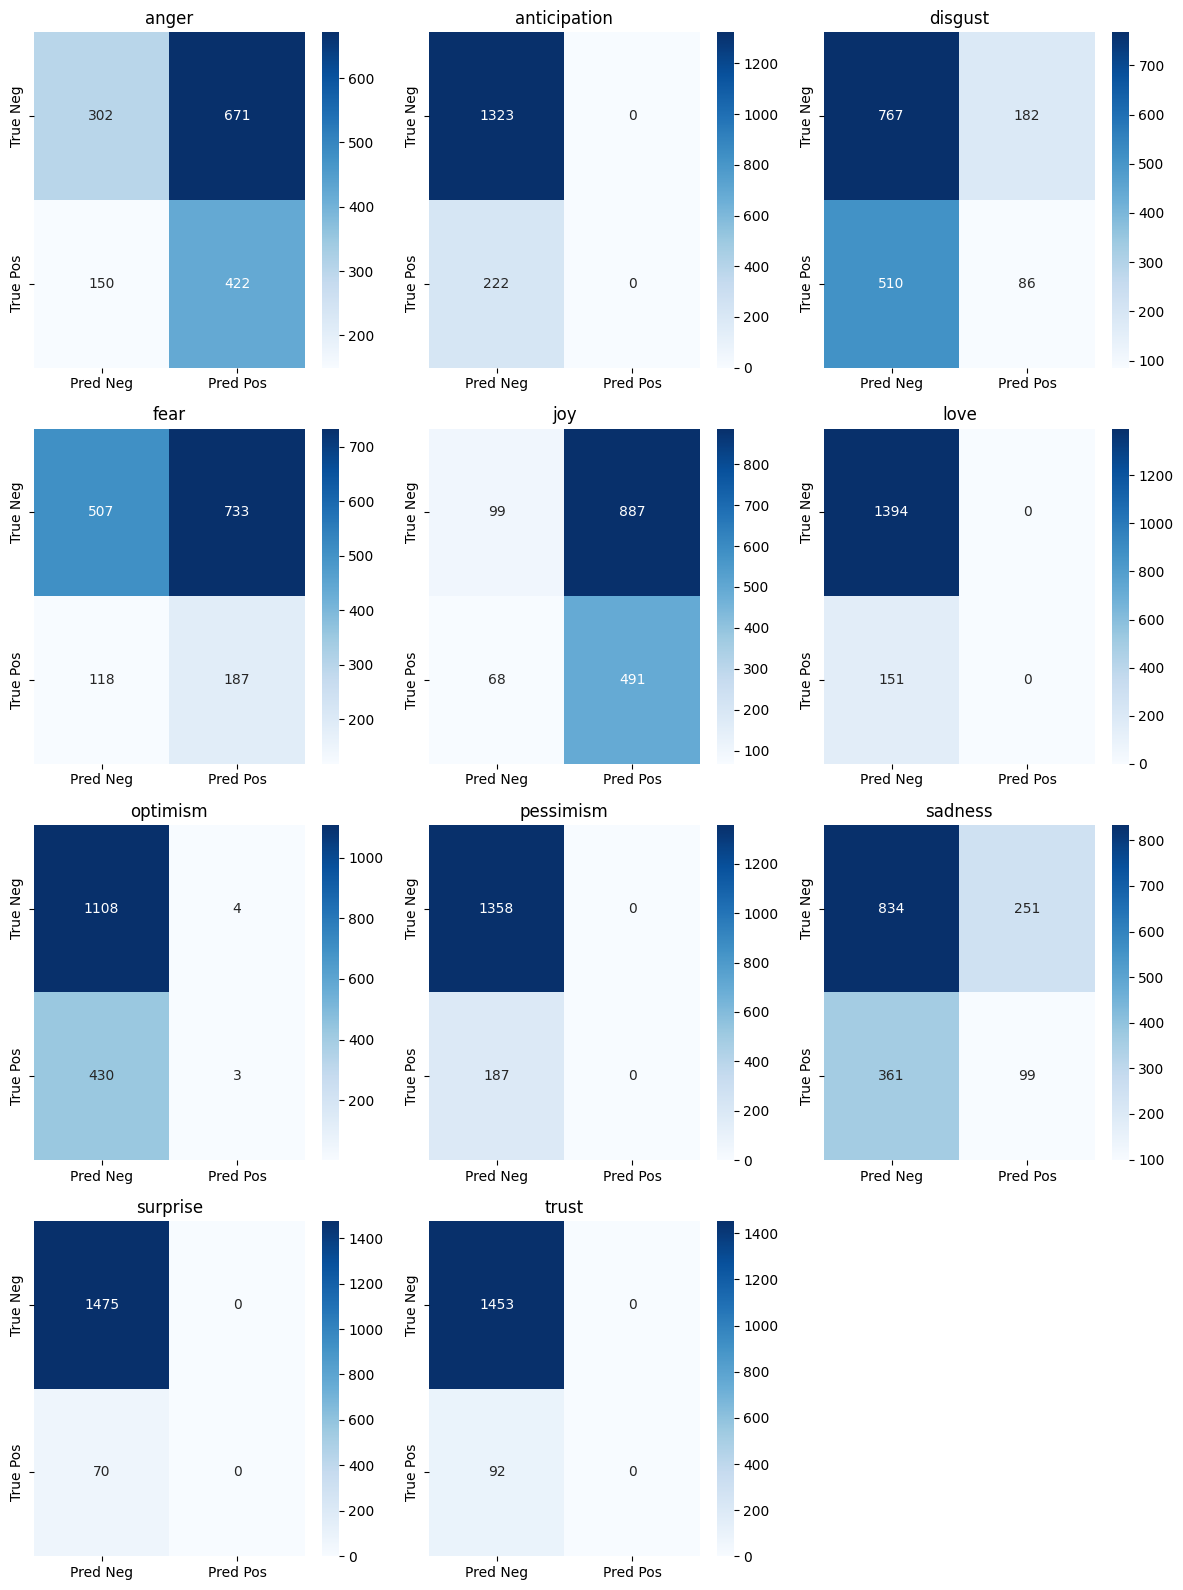

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


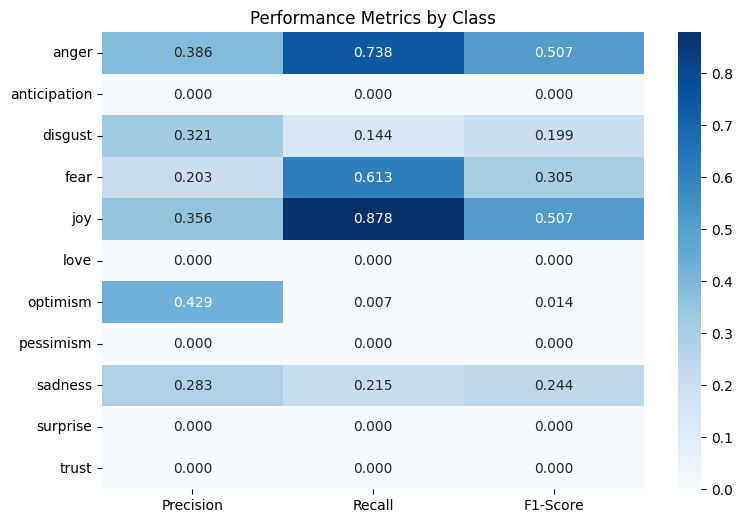

<Figure size 1200x533.333 with 0 Axes>

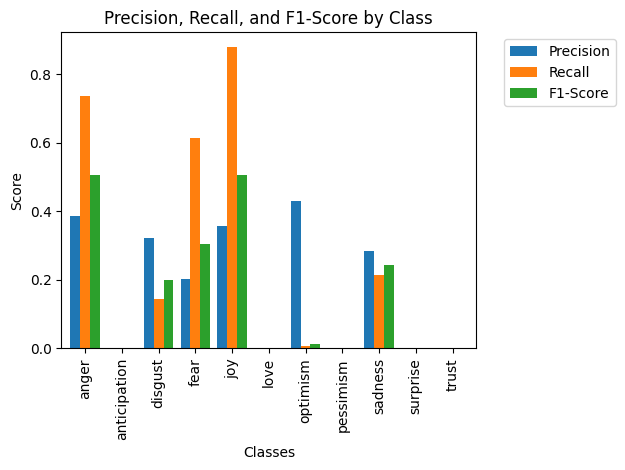

{'macro_avg': {'precision': 0.17981743475811568,
  'recall': 0.23597020868913468,
  'f1': 0.1614852229124869},
 'per_class': {'Precision': {'anger': 0.38609332113449224,
   'anticipation': 0.0,
   'disgust': 0.3208955223880597,
   'fear': 0.20326086956521738,
   'joy': 0.3563134978229318,
   'love': 0.0,
   'optimism': 0.42857142857142855,
   'pessimism': 0.0,
   'sadness': 0.28285714285714286,
   'surprise': 0.0,
   'trust': 0.0},
  'Recall': {'anger': 0.7377622377622378,
   'anticipation': 0.0,
   'disgust': 0.14429530201342283,
   'fear': 0.6131147540983607,
   'joy': 0.8783542039355993,
   'love': 0.0,
   'optimism': 0.006928406466512702,
   'pessimism': 0.0,
   'sadness': 0.21521739130434783,
   'surprise': 0.0,
   'trust': 0.0},
  'F1-Score': {'anger': 0.5069069069069069,
   'anticipation': 0.0,
   'disgust': 0.19907407407407407,
   'fear': 0.3053061224489796,
   'joy': 0.5069695405265875,
   'love': 0.0,
   'optimism': 0.013636363636363636,
   'pessimism': 0.0,
   'sadness': 0.2

In [ ]:
multilabel_evaluation(y_true=valid_labels_binary, y_pred=valid_predictions_binary, class_names=label_columns, figsize=(12, 8))

#  <font color = 'indianred'> **7. Performance on Test Set** </font>
For test set evaluation, we will perfrom following steps:



In [ ]:

test_val_subset= DatasetDict(
    {"test": dataset_dict['test']})
test_split =test_val_subset['test']

In [ ]:
test_split = test_split.map(filter_fn, desc="Processing dataset")

Processing dataset:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
testset_filtered = test_split.filter(lambda x: x['keep']).remove_columns(['keep'])

Filter:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
testset_filtered

Dataset({
    features: ['text', 'label'],
    num_rows: 3259
})

In [ ]:
free_gpu_memory()

In [ ]:
test_inference_results = run_inference(seed = 42,
              dataset=testset_filtered,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter,
              save_dir=model_folder,
              save_file_name = 'test_complete_generations')

Generating responses: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]


In [ ]:
file_name = model_folder/'test_complete_generations.json'
with open(file_name, 'r') as f:
    test_inference_results = json.load(f)

In [142]:
# Get predictions using our pipeline
# First extract content from model outputs
test_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in test_inference_results
]

# Clean and convert predictions and ground truth
test_predictions = [
    clean_and_split_labels(extracted_output, label_columns)
    for extracted_output in test_extracted_outputs
]

test_labels = [
    clean_and_split_labels(result['ground_truth'], label_columns)
    for result in test_inference_results
]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=label_columns)
mlb.fit(label_columns)  # Fit with all possible classes

# Transform the data
test_labels_binary = mlb.transform(test_labels)
test_predictions_binary = mlb.transform(test_predictions)

# Print samples and shapes
print("Sample of true labels:", test_labels[:5])
print("Sample of predictions:", test_predictions[:5])
print("\nBinary format:")
print("Labels shape:", test_labels_binary.shape)
print("Predictions shape:", test_predictions_binary.shape)

In [ ]:
test_metrics = compute_metrics(test_labels_binary , test_predictions_binary)

In [ ]:
test_metrics

In [ ]:
wandb.log({"test_f1_macro": test_metrics["f1_macro"]})

<font color = 'indianred'> *Confusion Matrix*</font>

In [ ]:
multilabel_evaluation(y_true=test_labels_binary, y_pred=test_predictions_binary, class_names=label_columns, figsize=(12, 8))

In [ ]:
wandb.finish()

# <Font color = 'indianred'> **8. Model Inference**



In [146]:
model_folder = model_folder/'llama_qlora_lmh'
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = "<|finetune_right_pad_id|>"
tokenizer.padding_side='left'

In [147]:
base_model_name

'meta-llama/Llama-3.2-1B-Instruct'

In [148]:
# inference_results= run_inference(seed = 42,
#               dataset=testset_filtered.select(range(10)),
#               model=model,
#               tokenizer=tokenizer,
#               per_device_batch_size=40,
#               prompt_template=prompt_template,
#               input_field=input_field,
#               output_field=output_field,
#               output_delimiter=output_delimiter)

inference_results= run_inference(seed = 42,
              dataset=testset_filtered,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              prompt_template=prompt_template,
              input_field=input_field,
              output_field=output_field,
              output_delimiter=output_delimiter)

Generating responses: 100%|██████████| 82/82 [01:19<00:00,  1.03it/s]


In [149]:
inference_results[0]

{'input': 'Do nt worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'generated_output': 'Classify the TEXT by selecting all applicable labels from the following list: ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]. ### TEXT: Do nt worry Indian army is on its ways to dispatch all Terrorists to Hell ### LABEL: [\'joy\', \'disness\']',
 'ground_truth': []}

In [150]:
extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in inference_results
]

In [151]:
# Clean and convert predictions and ground truth
predictions = [
    clean_and_split_labels(extracted_output, label_columns)
    for extracted_output in extracted_outputs
]

In [152]:

predictions

[['joy', 'sadness'],
 ['anger', 'fear', 'joy'],
 ['anger', 'disgust'],
 ['anger', 'fear', 'joy'],
 ['anger', 'fear', 'joy'],
 ['joy', 'fear', 'anger'],
 ['joy', 'disgust'],
 ['joy', 'sadness'],
 ['anger', 'fear', 'joy'],
 ['anger', 'fear', 'joy'],
 ['joy', 'sadness'],
 ['joy', 'disgust'],
 ['joy', 'sadness'],
 ['anger', 'disgust'],
 ['joy', 'disgust'],
 ['anger', 'sadness'],
 ['joy', 'sadness'],
 ['joy', 'disgust'],
 ['anger', 'disgust'],
 ['anger', 'sadness'],
 ['joy', 'sadness'],
 ['anger', 'fear', 'joy'],
 ['anger', 'fear', 'joy'],
 ['anger', 'fear', 'joy'],
 ['joy', 'disgust'],
 ['joy', 'disgust'],
 ['anger', 'fear', 'joy'],
 ['joy', 'sadness'],
 ['anger', 'fear', 'joy'],
 ['anger', 'fear', 'joy'],
 ['anger', 'fear', 'joy'],
 ['anger', 'sadness'],
 ['anger', 'fear', 'joy'],
 ['joy', 'sadness'],
 ['anger', 'fear', 'joy'],
 ['joy', 'sadness'],
 ['anger', 'fear', 'joy'],
 ['anger', 'fear', 'joy'],
 ['anger', 'disgust'],
 ['joy', 'disgust'],
 ['joy', 'disgust'],
 ['anger', 'fear', 'joy

In [153]:
def convert_to_binary(label_list, label_columns):
    label_to_index = {label: i for i, label in enumerate(label_columns)}
    binary_labels = []

    for labels in label_list:
        binary_row = [0] * len(label_columns)
        for label in labels:
            if label in label_to_index:
                binary_row[label_to_index[label]] = 1
        binary_labels.append(binary_row)

    return binary_labels

In [154]:
test_preds = convert_to_binary(predictions, label_columns)

In [155]:
df_test[label_columns] = test_preds

In [156]:
df_test.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,cleaned_tweet
0,2018-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,0,0,0,0,1,0,0,0,1,0,0,Do nt worry Indian army is on its ways to disp...
1,2018-03739,"Academy of Sciences, eschews the normally sobe...",1,0,0,1,1,0,0,0,0,0,0,Academy of Sciences eschews the normally sober...
2,2018-00385,I blew that opportunity -__- #mad,1,0,1,0,0,0,0,0,0,0,0,I blew that opportunity mad
3,2018-03001,This time in 2 weeks I will be 30... 😥,1,0,0,1,1,0,0,0,0,0,0,This time in 2 weeks I will be 30 sad_but_reli...
4,2018-01988,#Deppression is real. Partners w/ #depressed p...,1,0,0,1,1,0,0,0,0,0,0,Deppression is real Partners w depressed peopl...


In [157]:
submission = df_test.drop(columns = ['Tweet','cleaned_tweet'])
# submission = df_test.drop(columns = ['Tweet'])
submission.head(15)

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,0,0,0,0,1,0,0,0,1,0,0
1,2018-03739,1,0,0,1,1,0,0,0,0,0,0
2,2018-00385,1,0,1,0,0,0,0,0,0,0,0
3,2018-03001,1,0,0,1,1,0,0,0,0,0,0
4,2018-01988,1,0,0,1,1,0,0,0,0,0,0
5,2018-03463,1,0,0,1,1,0,0,0,0,0,0
6,2018-04315,0,0,1,0,1,0,0,0,0,0,0
7,2018-01426,0,0,0,0,1,0,0,0,1,0,0
8,2018-03332,1,0,0,1,1,0,0,0,0,0,0
9,2018-01938,1,0,0,1,1,0,0,0,0,0,0


In [158]:
submission.to_csv(model_folder/ 'Llama_instructmodel.csv', index = False)

In [159]:
#download the csv
from google.colab import files
files.download(model_folder/ 'Llama_instructmodel.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>